#### Installs

In [ ]:
!pip -q install -U datasets transformers accelerate evaluate sentence-transformers matplotlib

In [ ]:
!pip -q uninstall -y numpy scipy scikit-learn pandas
!pip -q install --no-cache-dir "numpy==2.0.2" "scipy==1.14.1" "scikit-learn==1.6.1" "pandas==2.2.2"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
from datetime import datetime

PROJECT_ROOT = "/content/drive/MyDrive/DL_project"
RUN_NAME = datetime.now().strftime("qqp_run_%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(PROJECT_ROOT, "runs", RUN_NAME)

os.makedirs(RUN_DIR, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RUN_DIR: /content/drive/MyDrive/DL_project/runs/qqp_run_20260130_133223


In [ ]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
)

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    import os
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(SEED)
print("transformers:", transformers.__version__)

transformers: 4.57.6


#### Dataset overview

In [ ]:
raw = load_dataset("glue", "qqp")

def clean_example(ex):
    q1 = ex["question1"] if ex["question1"] is not None else ""
    q2 = ex["question2"] if ex["question2"] is not None else ""
    ex["question1"] = q1.strip()
    ex["question2"] = q2.strip()
    return ex

def non_empty(ex):
    return len(ex["question1"]) > 0 and len(ex["question2"]) > 0

qqp_train = raw["train"].map(clean_example).filter(non_empty)
qqp_train

README.md: 0.00B [00:00, ?B/s]

qqp/train-00000-of-00001.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

qqp/validation-00000-of-00001.parquet:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

qqp/test-00000-of-00001.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Filter:   0%|          | 0/363846 [00:00<?, ? examples/s]

Dataset({
    features: ['question1', 'question2', 'label', 'idx'],
    num_rows: 363846
})

In [ ]:
df = qqp_train.to_pandas()[["question1", "question2", "label"]].copy()

train_df, temp_df = train_test_split(
    df, test_size=0.20, random_state=SEED, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["label"]
)

splits = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

print({k: len(v) for k, v in splits.items()})
splits

{'train': 291076, 'validation': 36385, 'test': 36385}


DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 291076
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 36385
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 36385
    })
})

        split  non_dup(0)  dup(1)
0       train      183574  107502
1  validation       22947   13438
2        test       22947   13438


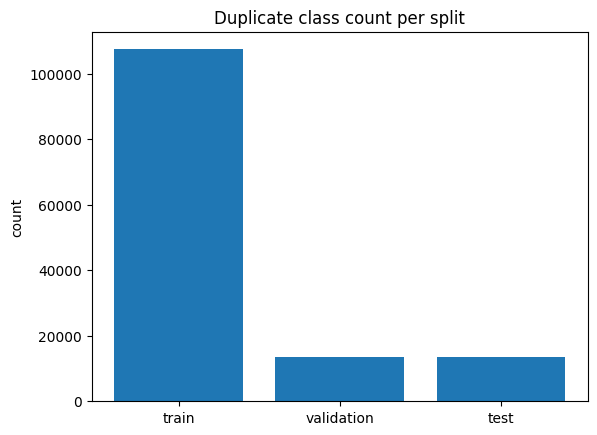

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_class_balance.csv


In [ ]:
def class_counts(ds):
    s = pd.Series(ds["label"]).value_counts().sort_index()
    return int(s.get(0,0)), int(s.get(1,0))

rows = []
for split_name in ["train", "validation", "test"]:
    n0, n1 = class_counts(splits[split_name])
    rows.append({"split": split_name, "non_dup(0)": n0, "dup(1)": n1})

eda_balance = pd.DataFrame(rows)
print(eda_balance)

plt.figure()
plt.bar(eda_balance["split"], eda_balance["dup(1)"])
plt.title("Duplicate class count per split")
plt.ylabel("count")
plt.show()

balance_path = os.path.join(RUN_DIR, "eda_class_balance.csv")
eda_balance.to_csv(balance_path, index=False)
print("Saved:", balance_path)

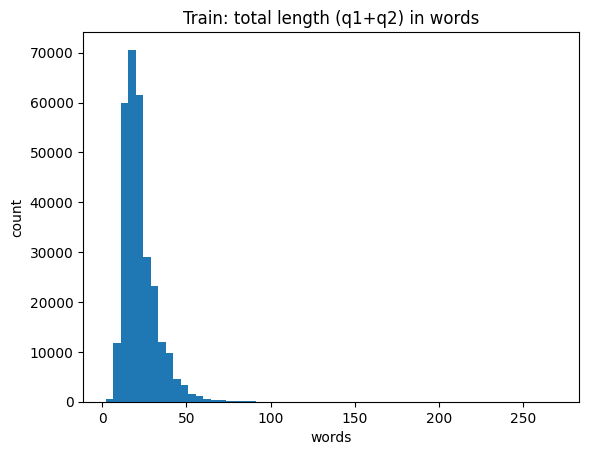

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_len_hist.png
Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_len_stats.csv


In [ ]:
def add_len_cols(df_):
    df_ = df_.copy()
    df_["len_q1"] = df_["question1"].str.split().apply(len)
    df_["len_q2"] = df_["question2"].str.split().apply(len)
    df_["len_sum"] = df_["len_q1"] + df_["len_q2"]
    return df_

eda_train = add_len_cols(train_df)

plt.figure()
plt.hist(eda_train["len_sum"], bins=60)
plt.title("Train: total length (q1+q2) in words")
plt.xlabel("words")
plt.ylabel("count")
len_plot_path = os.path.join(RUN_DIR, "eda_len_hist.png")
plt.savefig(len_plot_path, bbox_inches="tight")
plt.show()
print("Saved:", len_plot_path)

len_stats_path = os.path.join(RUN_DIR, "eda_len_stats.csv")
eda_train[["len_q1","len_q2","len_sum"]].describe().to_csv(len_stats_path)
print("Saved:", len_stats_path)

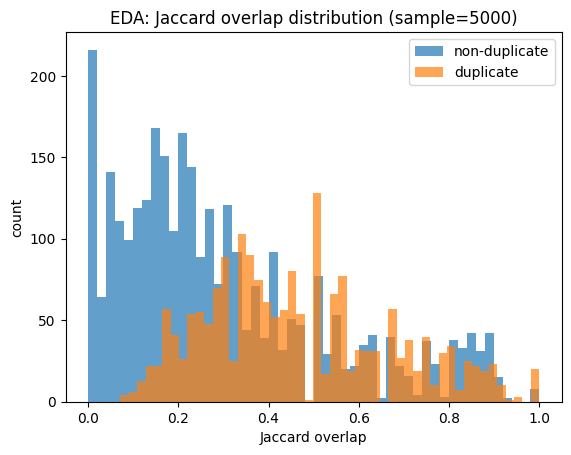

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_jaccard_hist.png


In [ ]:
def jaccard_overlap(q1, q2):
    s1 = set(re.findall(r"\w+", q1.lower()))
    s2 = set(re.findall(r"\w+", q2.lower()))
    if not s1 and not s2:
        return 0.0
    return len(s1 & s2) / max(1, len(s1 | s2))

sample = train_df.sample(5000, random_state=SEED).copy()
sample["jaccard"] = [jaccard_overlap(a,b) for a,b in zip(sample["question1"], sample["question2"])]

plt.figure()
plt.hist(sample[sample["label"]==0]["jaccard"], bins=50, alpha=0.7, label="non-duplicate")
plt.hist(sample[sample["label"]==1]["jaccard"], bins=50, alpha=0.7, label="duplicate")
plt.title("EDA: Jaccard overlap distribution (sample=5000)")
plt.xlabel("Jaccard overlap")
plt.ylabel("count")
plt.legend()

jacc_plot_path = os.path.join(RUN_DIR, "eda_jaccard_hist.png")
plt.savefig(jacc_plot_path, bbox_inches="tight")
plt.show()
print("Saved:", jacc_plot_path)

#### Metrics and confusion matrix

In [ ]:
def metrics_dict(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

def show_and_save_cm(y_true, y_pred, title, out_path):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

### Method 1: SentenceTransformer

#### Encode + tune threshold on val

In [ ]:
from sentence_transformers import SentenceTransformer

st_model_name = "sentence-transformers/all-MiniLM-L6-v2"
st_model = SentenceTransformer(st_model_name)

def get_embeddings(model, texts, batch_size=256):
    return model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

val_q1 = splits["validation"]["question1"]
val_q2 = splits["validation"]["question2"]
val_y  = np.array(splits["validation"]["label"])

val_emb1 = get_embeddings(st_model, val_q1)
val_emb2 = get_embeddings(st_model, val_q2)

# embeddings are normalized -> cosine = dot product
val_sim = np.sum(val_emb1 * val_emb2, axis=1)

def tune_threshold(sim, y_true):
    thresholds = np.linspace(-0.1, 0.95, 106)
    best_thr, best_f1 = None, -1
    for thr in thresholds:
        pred = (sim >= thr).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)
    return best_thr, best_f1

best_thr, best_f1 = tune_threshold(val_sim, val_y)
print("Best threshold (val):", best_thr, "Best F1:", best_f1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Best threshold (val): 0.74 Best F1: 0.7417799752781211


#### SentenceTransformer: evaluate on test

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

ST TEST metrics: {'accuracy': 0.7633090559296414, 'f1': 0.7343615052436767, 'precision': 0.6271204298809399, 'recall': 0.8858461080517934}


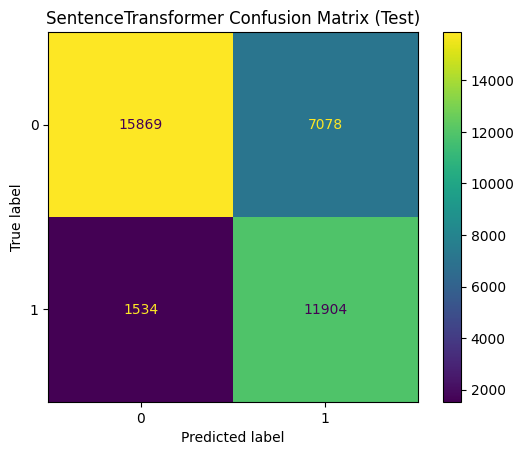

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/cm_st_test.png


In [ ]:
test_q1 = splits["test"]["question1"]
test_q2 = splits["test"]["question2"]
test_y  = np.array(splits["test"]["label"])

test_emb1 = get_embeddings(st_model, test_q1)
test_emb2 = get_embeddings(st_model, test_q2)
test_sim = np.sum(test_emb1 * test_emb2, axis=1)

st_test_pred = (test_sim >= best_thr).astype(int)

st_metrics = metrics_dict(test_y, st_test_pred)
print("ST TEST metrics:", st_metrics)

st_cm_path = os.path.join(RUN_DIR, "cm_st_test.png")
show_and_save_cm(test_y, st_test_pred, "SentenceTransformer Confusion Matrix (Test)", st_cm_path)

pd.DataFrame([{"model":"SentenceTransformer", **st_metrics}]).to_csv(
    os.path.join(RUN_DIR, "st_test_metrics.csv"), index=False
)

### Method 2: BERT classifier

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 128

def tokenize_batch(batch):
    return tokenizer(
        batch["question1"],
        batch["question2"],
        truncation=True,
        max_length=MAX_LEN
    )

train_tok = splits["train"].map(tokenize_batch, batched=True)
val_tok   = splits["validation"].map(tokenize_batch, batched=True)
test_tok  = splits["test"].map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/291076 [00:00<?, ? examples/s]

Map:   0%|          | 0/36385 [00:00<?, ? examples/s]

Map:   0%|          | 0/36385 [00:00<?, ? examples/s]

In [ ]:
def metrics_dict(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

def hf_compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metrics_dict(labels, preds)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
EVAL_STEPS = 4500
training_args = TrainingArguments(
    output_dir=os.path.join(RUN_DIR, "checkpoints"),
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=EVAL_STEPS,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=1e-5,
    weight_decay=0.10,
    label_smoothing_factor=0.1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=200,
    report_to="none",
    fp16=False,
    bf16=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    compute_metrics=hf_compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_output = trainer.train()
train_output

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
4500,0.413633,0.402537,0.870634,0.800427,0.865531,0.831707
9000,0.386304,0.377855,0.884595,0.834141,0.858163,0.845982
13500,0.384206,0.374204,0.891494,0.837482,0.876246,0.856426
18000,0.365747,0.369654,0.895616,0.833934,0.895743,0.863734
22500,0.342039,0.377515,0.894847,0.875586,0.833755,0.854159
27000,0.350187,0.365387,0.899821,0.864947,0.863596,0.864271
31500,0.345644,0.367411,0.904219,0.846867,0.904152,0.874573
36000,0.359628,0.356905,0.906280,0.854246,0.899762,0.876413
40500,0.320723,0.373115,0.906940,0.859514,0.894181,0.876504
45000,0.326077,0.375391,0.906417,0.852406,0.902962,0.876956


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=54579, training_loss=0.3576258875315098, metrics={'train_runtime': 11733.6851, 'train_samples_per_second': 74.421, 'train_steps_per_second': 4.651, 'total_flos': 2.67325354467024e+16, 'train_loss': 0.3576258875315098, 'epoch': 3.0})

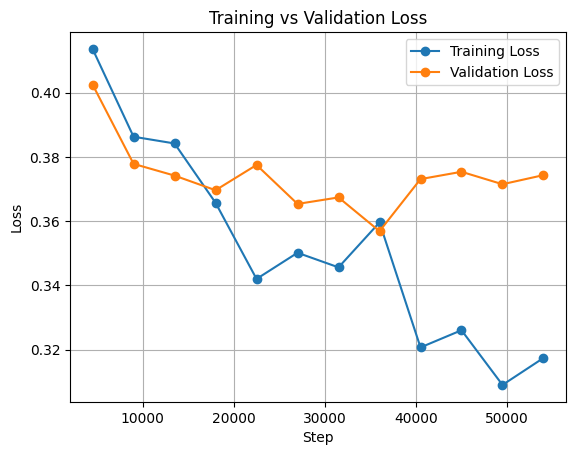

In [2]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
train_df = df[df["loss"].notna()][["step", "loss"]].copy()
eval_df = df[df["eval_loss"].notna()][["step", "eval_loss"]].copy()
plt.figure()
if len(train_df):
    plt.plot(train_df["step"], train_df["loss"], label="train loss")
if len(eval_df):
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="val loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.show()
print(df.columns)

In [ ]:
test_metrics = trainer.evaluate(test_tok)
print("TEST metrics:", test_metrics)

out = {
    "model": model_name,
    "max_len": MAX_LEN,
    "eval_steps": EVAL_STEPS,
    "test_accuracy": test_metrics.get("eval_accuracy"),
    "test_precision": test_metrics.get("eval_precision"),
    "test_recall": test_metrics.get("eval_recall"),
    "test_f1": test_metrics.get("eval_f1"),
}
pd.DataFrame([out]).to_csv(os.path.join(RUN_DIR, "test_metrics.csv"), index=False)
print("Saved:", os.path.join(RUN_DIR, "test_metrics.csv"))

TEST metrics: {'eval_loss': 0.3658513128757477, 'eval_accuracy': 0.9117768311117218, 'eval_precision': 0.8688158084523294, 'eval_recall': 0.8964875725554398, 'eval_f1': 0.8824348080867273, 'eval_runtime': 130.9706, 'eval_samples_per_second': 277.81, 'eval_steps_per_second': 8.689, 'epoch': 3.0}
Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_final_full/test_metrics.csv


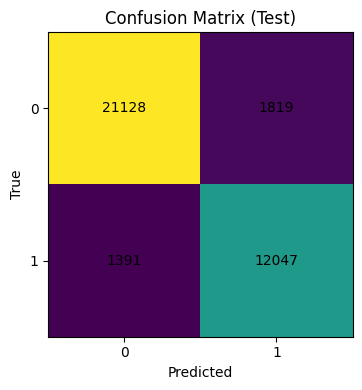

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_final_full/cm_test.png


In [ ]:
pred_out = trainer.predict(test_tok)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4.5, 4.0))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()

cm_path = os.path.join(RUN_DIR, "cm_test.png")
plt.savefig(cm_path, dpi=200)
plt.show()
print("Saved:", cm_path)

In [ ]:
final_dir = os.path.join(RUN_DIR, "final_model")
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print("Saved final model to:", final_dir)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved final model to: /content/drive/MyDrive/DL_project/runs/qqp_run_final_full/final_model


### Comparison

                 model  accuracy        f1  precision    recall
0  SentenceTransformer  0.763309  0.734362    0.62712  0.885846
1                 BERT  0.911000  0.882000    0.86800  0.896000


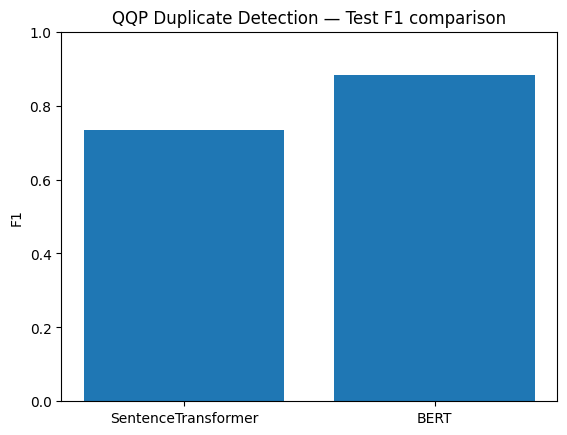

In [4]:
compare = pd.DataFrame([
    {
        "model": "SentenceTransformer",
        "accuracy": st_metrics["accuracy"],
        "precision": st_metrics["precision"],
        "recall": st_metrics["recall"],
        "f1": st_metrics["f1"],
    },
    {
        "model": "BERT",
        "accuracy": test_metrics["eval_accuracy"],
        "precision": test_metrics["eval_precision"],
        "recall": test_metrics["eval_recall"],
        "f1": test_metrics["eval_f1"],
    },
])

print(compare)

plt.figure()
plt.bar(compare["model"], compare["f1"])
plt.title("QQP Duplicate Detection — Test F1 comparison")
plt.ylabel("F1")
plt.ylim(0, 1)
plt.show()